# 6. Force and the added mass

## Force

This part introduces the calculation of the force and moment on the body through the negative rate of change of impulse in the fluid. The continuous expressions for linear and angular impulse (about the origin) are, in two dimensions,

$\begin{align}
    \boldsymbol{P} &= \int_{V_f} \boldsymbol{x}\times \boldsymbol{\omega}\,\mathrm{d}V + \int_{S_b} \boldsymbol{x}\times \left( \boldsymbol{n}\times\boldsymbol{v}\right)\,\mathrm{d}S \\
    \boldsymbol{\Pi}_0 &= \frac{1}{2}\int_{V_f} \boldsymbol{x}\times \left(\boldsymbol{x}\times\boldsymbol{\omega}\right)\,\mathrm{d}V + \frac{1}{2} \int_{S_b} \boldsymbol{x}\times \left[ \boldsymbol{x}\times\left( \boldsymbol{n} \times \boldsymbol{v} \right) \right] \,\mathrm{d}S
\end{align}$

If there is only a single body, then the force and moment (about the origin) exerted by the fluid on that body are given by

$\boldsymbol{F} = -\rho \frac{\mathrm{d}\boldsymbol{P}}{\mathrm{d}t}, \qquad \boldsymbol{M}_{0} = -\rho \frac{\mathrm{d}\boldsymbol{\Pi}_{0}}{\mathrm{d}t},$

where $\rho$ is the fluid density. In the two-dimensional applications of this package, angular impulse and the moment have only a single component, e.g., $\boldsymbol{\Pi}_0 =\Pi_0\boldsymbol{e}_z$, where $\boldsymbol{e}_z$ is the unit vector out of the plane.

#### Point vortices past a cylinder

To verify our method of calculating the impulse, we create a model of two point vortices of equal and opposite circulation positioned at both sides of the $x$-axis, with the $x$-axis as axis of symmetry, and left of a circular cylinder positioned at the origin. If the top vortex has a positive circulation, the vortices propel each other towards the cylinder and convect past it. This configuration has an analytical solution for the trajecory and impulse.

We use a rectangular grid.

In [1]:
using GridPotentialFlow
using Plots
Lx = 10.0
Ly = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Ly/2,Ly/2)
g = PhysicalGrid(xlim, ylim, 0.04)

PhysicalGrid{2}((252, 104), (126, 52), 0.04, ((-5.0, 5.0), (-2.04, 2.04)))

In [2]:
Rc = 1
circle = Circle(Rc,2*cellsize(g))
Δs = dlength(circle);

The initial spacing between the vortices is `y∞`. After the vortices pass the cylinder, they should return to this spacing.

In [3]:
y∞ = Rc/2
v1 = Vortex(-Lx/2+10*cellsize(g),y∞,1.0);
v2 = Vortex(-Lx/2+10*cellsize(g),-y∞,-1.0);

We create the vortex model with these two point vortices and the circle and advance the position of the point vortices over some time. During the time stepping, we compute the impulse with `computeimpulse` and store its history.

In [4]:
model = VortexModel(g,bodies=[circle],vortices=[v1,v2])
w = computew(model)
sol = solvesystem(model,w);

Analytical trajectory

In [5]:
x(r) = sqrt(r^2-(y∞^2*(r^2-1)^2)/((r^2-1)^2-4*y∞^2))
y(r) = y∞*(r^2-1)/sqrt((r^2-1)^2-4*y∞^2)
s = 0:0.001:π/2
rmin = 1.4375649
c1 = rmin/(-Lx/2+rmin)
c2 = -Lx/2*c1
r = c2 ./ (cos.(s).-c1)
x_trajectory = -reverse(x.(r)); append!(x_trajectory,x.(r))
y_trajectory_upper = reverse(y.(r)); append!(y_trajectory_upper,y.(r))
y_trajectory_lower = -y_trajectory_upper;

Analytical impulse

In [6]:
Px_func(x,y) = y - y/(x^2+y^2) + y - y/(x^2+y^2);
Py_func(x,y) = -x + x/(x^2+y^2) + x - x/(x^2+y^2);
Px_exact = Px_func.(x_trajectory,y_trajectory_upper);
Py_exact = Py_func.(x_trajectory,y_trajectory_upper);

Δt = 0.1
T = 0:Δt:64.0
X_hist = []
Px_numerical_hist = []
Py_numerical_hist = []

for t in T
    Ẋ = computevortexvelocities(model)
    vortices = deepcopy(model.vortices.list)

    X = getvortexpositions(model)
    X = X + Ẋ*Δt
    setvortexpositions!(model,X)

    push!(X_hist,X)

    Px, Py = computeimpulse(model)
    push!(Px_numerical_hist,Px)
    push!(Py_numerical_hist,Py)
end

When we compare the trajectories and impulse history, the numerical and anaylytical solution should match closely, which is indeed the case.

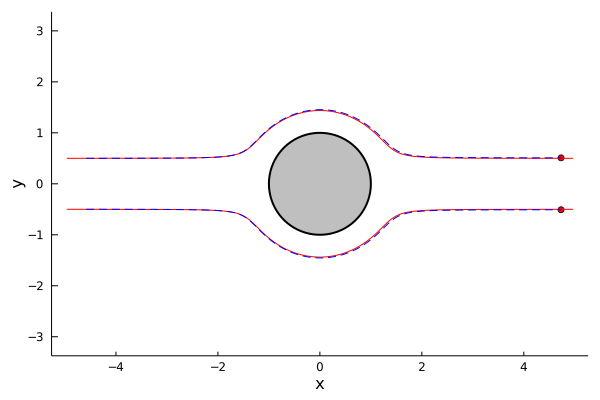

In [7]:
plot(circle,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2,xlabel="x",ylabel="y")
scatter!((v->v.x).(model.vortices.list),(v->v.y).(model.vortices.list),color=:red)
plot!(x_trajectory,y_trajectory_upper,linecolor=:red,label="exact")
plot!(x_trajectory,y_trajectory_lower,linecolor=:red,label="")
plot!((X->X[1]).(X_hist),(X->X[3]).(X_hist),color=:blue,linestyle=:dash,label="simulated")
plot!((X->X[2]).(X_hist),(X->X[4]).(X_hist),color=:blue,linestyle=:dash,label="")

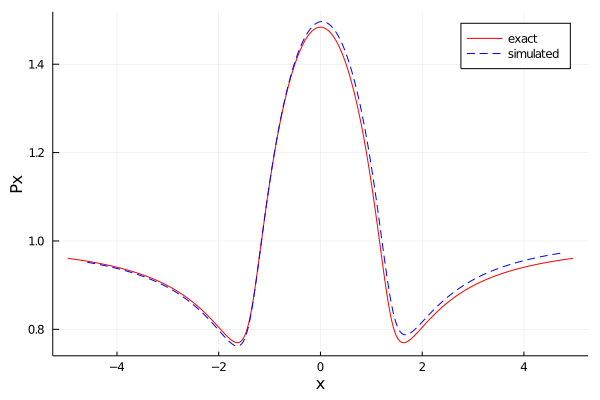

In [8]:
plot(x_trajectory,Px_exact,color=:red,label="exact",xlabel="x",ylabel="Px")
plot!((X->X[1]).(X_hist),Px_numerical_hist,color=:blue,linestyle=:dash,label="simulated")

#### Flat plate

We can apply this method also to our flat plate example and compare it to the Biot-Savart method from the `PotentialFlow.jl` package.

Because we create the `PotentialFlow.jl` model with a moving plate instead of a uniform flow, we specify a translational velocity. The `GridPotentialFlow.jl` model will still use a moving body coordinate system and thus a uniform flow that equals the negative translational velocity.

In [9]:
c = 1.0;   # chord length

ċ = -1.0;  # translational velocity
α = -π/3;   # angle of attack

σLE = 0.0;
σTE = 0.0;

Δt = 5e-2;
tf = 1.0;
T = 0.0:Δt:tf;

Potential Flow

In [10]:
using PotentialFlow
function compute_ẋ!(ẋ, x, t)
    plate, ambient_sys = x
    motion = ẋ[1]
    motion.ċ, motion.c̈, motion.α̇ = motion.kin(t)
    Plates.enforce_no_flow_through!(plate, motion, ambient_sys, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end
function shed_new_vorticity!(blobs, plate, motion, t, lesp = 0.0, tesp = 0.0)
    z₊ = (blobs[end-1].z + 2plate.zs[end])/3
    z₋ = (blobs[end].z + 2plate.zs[1])/3
#!md
    blob₊ = PotentialFlow.Vortex.Blob(z₊, 1.0, δ)
    blob₋ = PotentialFlow.Vortex.Blob(z₋, 1.0, δ)
    Plates.enforce_no_flow_through!(plate, motion, blobs, t)
#!md
    Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, blob₊, blob₋, t, lesp, tesp);
    push!(blobs, PotentialFlow.Vortex.Blob(z₊, Γ₊, blobs[1].δ), PotentialFlow.Vortex.Blob(z₋, Γ₋, blobs[1].δ))
end
N = 128 # number of plate control points (distributed along a extrema Chebyshev grid)
δ = 0.01
plate = PotentialFlow.Plate(N, c, zero(ComplexF64), α)
motion = Plates.RigidBodyMotion(ċ, 0.0);

Initial step

In [11]:
Δz₀ = im*3Δt*exp(im*plate.α) # vectors perpendicular to the plate
z₋, z₊ = plate.zs[[1,N]] # LE and TE
blobs = PotentialFlow.Vortex.Blob.(Δz₀ .+ [z₊, z₋], 1.0, δ) # First two point vortices are placed close to the LE and TE with unit strength
Plates.enforce_no_flow_through!(plate, motion, (), 0)
Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, blobs[1], blobs[2], 0.0, σLE, σTE); # Determine strength of first two vortices

blobs = PotentialFlow.Vortex.Blob.(Δz₀ .+ [z₊, z₋], [Γ₊, Γ₋], δ) # Create first two point vortices now with calculated strengths

In [12]:
sys₀ = (plate, blobs)
sys = deepcopy(sys₀)
sys₊ = deepcopy(sys₀) # Used for storage during time-marching
ẋs = (motion, allocate_velocity(blobs))
imp = ComplexF64[];
t_hist = Float64[]
global t = 0
push!(t_hist,t)
push!(imp,Elements.impulse(sys));

Time stepping

In [13]:
for tloc in T[2:end]
    global t += Δt
    global sys
    global sys₊
    push!(t_hist,t)
    plate, ambient_ω = sys
    motion, ambient_u = ẋs
    resize!(sys₊[2], length(sys[2]))
    forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    sys, sys₊ = sys₊, sys
    shed_new_vorticity!(sys[2], sys[1], ẋs[1], t, σLE, σTE)
    push!(imp,Elements.impulse(sys))
end
force = -diff(imp)/Δt;

Δx = 0.01
xlim = (-0.5,2)
ylim = (-1,1)
g = PhysicalGrid(xlim,ylim,Δx);

In [14]:
dsdx = 2
plate = RigidBodyTools.Plate(c,dsdx*Δx)
transform = RigidTransform((0.0,0.0),-π/3)
transform(plate);
Δs = dlength(plate)
maximum(Δs/Δx);

As before, we create the initial vortices based on the time step and uniform flow and define a function that create the new point vortices for the subsequent time steps.

In [15]:
firstvLE = GridPotentialFlow.Vortex(plate.x[1]+3Δt*(-ċ)*cos(plate.α+π/2),plate.y[1]+3Δt*(-ċ)*sin(plate.α+π/2),0.0);
firstvTE = GridPotentialFlow.Vortex(plate.x[end]+3Δt*(-ċ)*cos(plate.α+π/2),plate.y[end]+3Δt*(-ċ)*sin(plate.α+π/2),0.0);

In [16]:
function createsheddedvortices(plate,oldvortices)

    vLE = GridPotentialFlow.Vortex(2/3*plate.x[1]+1/3*oldvortices[end-1].x,2/3*plate.y[1]+1/3*oldvortices[end-1].y,0.0)
    vTE = GridPotentialFlow.Vortex(2/3*plate.x[end]+1/3*oldvortices[end].x,2/3*plate.y[end]+1/3*oldvortices[end].y,0.0)

    return vLE,vTE
end

createsheddedvortices (generic function with 1 method)

The model parameters should specify the uniform velocity as the negative translational velocity of the plate.

In [17]:
model = VortexModel(g,bodies=[plate],edges=[1,length(plate)],vortices=[firstvLE,firstvTE]);
modelParameters = ModelParameters(U∞=(-ċ,0.0),σ=[SuctionParameter(σLE),SuctionParameter(σTE)]);

The first impulse we record is with the first two vortices. Note that the `computeimpulse` function internally calls the `solvesystem` method so it sets the strengths of the new vortices and such that they are correctly accounted for in the impulse calculation.

In [18]:
Px_hist = Float64[];
Py_hist = Float64[];
Px, Py = computeimpulse(model,parameters=modelParameters);
push!(Px_hist,Px);
push!(Py_hist,Py);

Then we enter a time loop and record the impulse every time we create new vortices.

In [19]:
for tloc in T[2:end]
    Ẋ = computevortexvelocities(model,parameters=modelParameters)
    vortices = deepcopy(model.vortices.list)
    updateposition!.(vortices,Ẋ.u,Ẋ.v,Δt)
    setvortices!(model,vortices)

    vLE, vTE = createsheddedvortices(plate,model.vortices.list)
    pushvortices!(model,vLE,vTE)

    Px, Py = computeimpulse(model,parameters=modelParameters)
    push!(Px_hist,Px)
    push!(Py_hist,Py)
end

The force history can be obtained by finite differencing the impulse history.

In [20]:
Fx_hist = -diff(Px_hist)/Δt;
Fy_hist = -diff(Py_hist)/Δt;

We can now compare the positions of the point vortices by shifting the `PotentialFlow.jl` solution by `-tf*ċ` such that the origin of the frame of reference coincides with the center plate. Superimposingt the `GridPotentialFlow.jl` solution then shows that the positions of the point vortices agree very well.

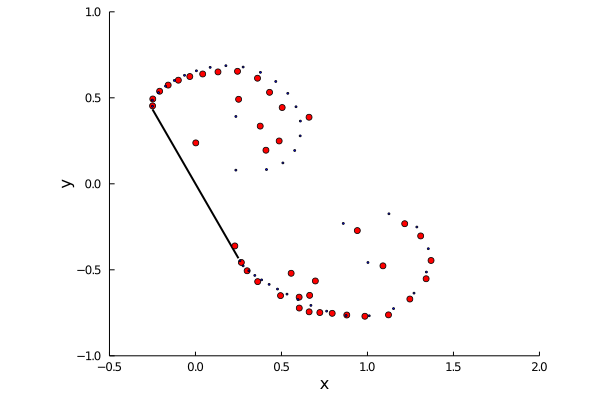

In [21]:
plot(plate,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2,xlim=xlim,ylim=ylim,xlabel="x",ylabel="y")
scatter!(real.((v->v.z).(sys[2])).-tf*ċ,imag.((v->v.z).(sys[2])),color=:red,markersize=4,label="PotentialFlow.jl")
scatter!((v->v.x).(model.vortices.list),(v->v.y).(model.vortices.list),color=:blue,markersize=2,label="GridPotentialFlow.jl")

The vertical impulse and the vertical force (lift) can also be compared and show good agreement as well.

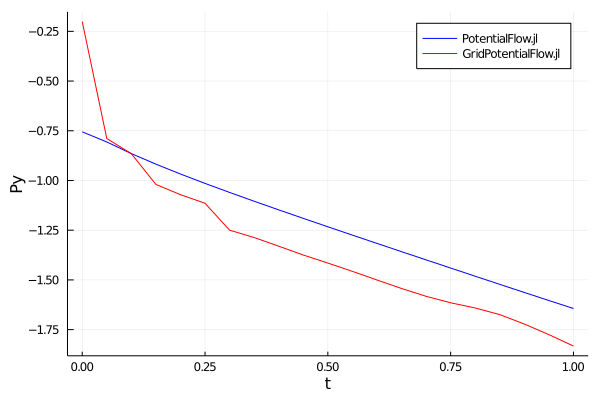

In [22]:
plot(xlabel="t",ylabel="Py")
plot!(T,Py_hist,color=:blue,label="PotentialFlow.jl")
plot!(T,imag.(imp),color=:red,label="GridPotentialFlow.jl")

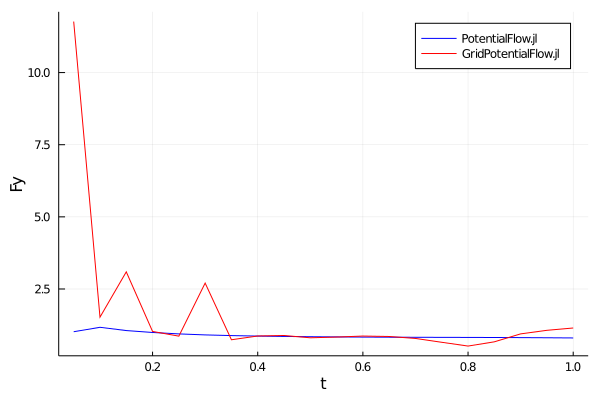

In [23]:
plot(xlabel="t",ylabel="Fy")
plot!(T[2:end],Fy_hist,color=:blue,label="PotentialFlow.jl")
plot!(T[2:end],imag.(force),color=:red,label="GridPotentialFlow.jl")

## Added mass

The added mass tensor provides a measure of the inertial influence of the fluid on the body in response to changes in the body's translational or rotational motion. The coefficients of the added mass tensor of a body are obtained by computing the impulse components associated with a unit-valued component of motion. The motion's influence is both direct, via the surface velocity, and indirect, in the bound vortex sheet that develops on the surface.

The added mass for simple geometries can easiliy be calculated in an analytical way. For example, the entries of the translational added mass tensor for an ellipse with semi-major axis $a$ and semi-minor axis $b$ are $m_{xx} = \rho \pi b^2$ for motion in the $x$ direction, $m_{yy} = \rho \pi a^2$ for motion in the $y$-direction, with the diagonal entries $m_{xy}=m_{yx}=0$. By using `computeaddedmassmatrix` from this package we can approximate these results numerically. In this case, we have one body and the method will return a matrix with the entries

$\begin{bmatrix}
m_{xx} & m_{xy} \\
m_{yx} & m_{yy}
\end{bmatrix}.$

In [24]:
Lx = 2.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,0.01)
Δx = cellsize(g);


a = 0.5
b = 0.25
ellipse = Ellipse(a,b,Δx)
model = VortexModel(g,bodies=[ellipse])
M = computeaddedmassmatrix(model)

2×2 Array{Float64,2}:
  0.209533     -2.32453e-16
 -2.01445e-16   0.804095

We can compare the values using the `@test` macro.

In [25]:
using Test
@test isapprox(M[1,1], π*b^2, rtol=1e-1)

Test Passed

In [26]:
@test isapprox(M[2,2], π*a^2, atol=1e-1)

Test Passed

In the case of $N$ bodies, `computeaddedmassmatrix` returns the translational added mass tensor of size $2N$-by-$2N$. As an example, we will compute the added mass tensor for an array of cylinders. To compare it with an analytically obtained solution, we will calculate the added mass matrix tensor for the following gap-to-radius ratios.

In [27]:
GRratios = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0,1.2,1.4,1.6];


function rectangulararray(rows,columns,spacing)
     centers = VectorData(rows*columns)
     for j in 1:columns
        for i in 1:rows
            xc = (i-1)*spacing
            yc = (j-1)*spacing
            centers.u[(j-1)*rows+i] = xc
            centers.v[(j-1)*rows+i] = yc
        end
    end
    centers.u .-= mean(centers.u)
    centers.v .-= mean(centers.v)
    return centers
 end

rectangulararray (generic function with 1 method)

For this case, the array consists of three rows of three cylinders.

In [28]:
n = 100
rows = 3
columns = 3
N = rows*columns
R = 0.20
𝒱 = π*R^2
bodies = fill(Circle(R,2*cellsize(g)),N);
Δs = minimum(dlength(bodies[1]));

We loop over the gap-to-radius ratios, position the bodies, and compute the ratio of the largest eigenvalue to the largest diagonal element of the translational added mass tensor. To position the bodies, we defined the method `rectangulararray` (see notebook in the examples folder).

In [29]:
using Statistics: mean
using LinearAlgebra: eigen

In [30]:
λoverMratios = zeros(length(GRratios))
for idx in 1:length(GRratios)
    global bodies
    gap = GRratios[idx]*R
    spacing = 2*R+gap
    bodycenters = rectangulararray(rows,columns,spacing)
    for i in 1:N
        T = RigidTransform((bodycenters.u[i],bodycenters.v[i]),0.0)
        global bodies[i] = T(deepcopy(bodies[i]))
    end
    bodylist = BodyList(bodies)
    model = VortexModel(g,bodies=bodylist);
    M = computeaddedmassmatrix(model)/𝒱
    eigM = eigen(M);
    max_eig_value_coef = maximum(real(eigM.values))
    max_self_added_mass_coef = maximum(M)
    λoverMratios[idx] = max_eig_value_coef/max_self_added_mass_coef
end

The same ratios, obtained in an analytical way, are available in literature [^1] and can be used to verify the numerical values.

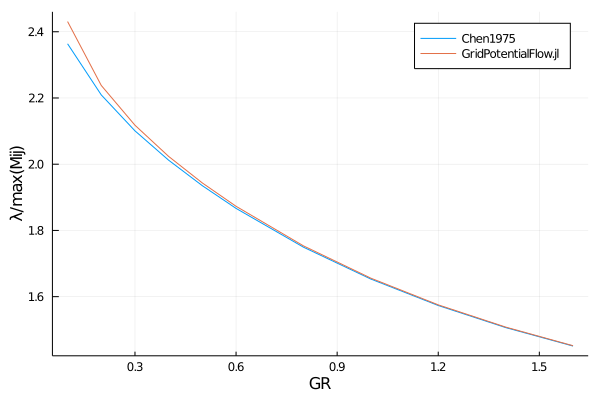

In [31]:
nineRodArrayChen = [2.3637,2.2092,2.1007,2.0120,1.9350,1.8665,1.7494,1.6531,1.5732,1.5066,1.4508];
plot(xlabel="GR",ylabel="λ/max(Mij)")
plot!(GRratios,nineRodArrayChen,label="Chen1975")
plot!(GRratios,λoverMratios,label="GridPotentialFlow.jl")

[^1]: Chen, S. S. (1975) "Vibration of nuclear fuel bundles," *Nuclear Engineering and Design*, 35 (3), 399-–422.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*